# Data Processing: events360_v2.jsonl

This notebook applies the following steps:
- Remove unique identifiers (`event_uuid`, `id`, `assisted_shot_id`, `key_pass_id`, `related_events`).
- Replace `pass.recipient` with `pass.recipient_position` (from lineups).
- Standardize missingness:
  - Booleans: missing -> `False`.
  - Categoricals: missing -> `Unknown` (as `{'id': None, 'name': 'Unknown'}`).
- Compute feature non-null counts and drop features below a coverage threshold.


In [35]:
from pathlib import Path
import json
from collections import Counter

DATA_PATH = Path('open-data/data/processed/events360_v2.jsonl')
LINEUPS_DIR = Path('open-data/data/lineups')
OUTPUT_PATH = Path('open-data/data/processed/events360_v4.jsonl')
THRESHOLD_PCT = 0.01  # 1%

print(DATA_PATH.resolve())

/Users/ziyuelin/Library/Mobile Documents/com~apple~CloudDocs/University/UToronto/STA2453/MLSE/open-data/data/processed/events360_v2.jsonl


In [36]:
def load_json(path: Path):
    with path.open('r', encoding='utf-8') as f:
        return json.load(f)


def build_lineup_position_map(lineups_data):
    positions = {}
    for team in lineups_data:
        for player in team.get('lineup', []):
            pid = player.get('player_id')
            pos_list = player.get('positions') or []
            if pid is None or not pos_list:
                continue
            pos = pos_list[0]
            pos_id = pos.get('position_id')
            pos_name = pos.get('position')
            if pos_id is None and pos_name is None:
                continue
            positions[int(pid)] = {'id': pos_id, 'name': pos_name}
    return positions


def normalize_booleans(details, bool_keys):
    for key in bool_keys:
        if key not in details or details.get(key) is None:
            details[key] = False


def normalize_categoricals(details, cat_keys):
    for key in cat_keys:
        if key not in details or details.get(key) is None:
            details[key] = {'id': None, 'name': 'Unknown'}


In [37]:
# Build per-match lineup position maps once
lineup_maps = {}
for fp in LINEUPS_DIR.glob('*.json'):
    match_id = fp.stem
    try:
        lineup_maps[match_id] = build_lineup_position_map(load_json(fp))
    except Exception:
        lineup_maps[match_id] = {}

print('Lineup maps:', len(lineup_maps))

Lineup maps: 3464


In [38]:
# Transform events and collect flattened feature coverage

counts = Counter()
rows = 0

# Count non-null occurrences for each flattened key

def add_counts(prefix, obj):
    if isinstance(obj, dict):
        for k, v in obj.items():
            add_counts(prefix + [k], v)
    elif isinstance(obj, list):
        if len(obj) > 0:
            counts['.'.join(prefix)] += 1
    else:
        if obj is not None:
            counts['.'.join(prefix)] += 1


def process_event(ev):
    # Drop unique identifiers
    ev.pop('event_uuid', None)
    ev.pop('id', None)
    ev.pop('related_events', None)

    # Pass normalization
    p = ev.get('pass')
    if isinstance(p, dict):
        p.pop('assisted_shot_id', None)
        recipient = p.pop('recipient', None)
        if isinstance(recipient, dict):
            rid = recipient.get('id')
            lineup_positions = lineup_maps.get(str(ev.get('match_id')), {})
            if rid is not None and int(rid) in lineup_positions:
                p['recipient_position'] = lineup_positions[int(rid)]

        normalize_booleans(
            p,
            ['backheel', 'deflected', 'miscommunication', 'cross', 'cut_back', 'switch', 'shot_assist', 'goal_assist']
        )
        normalize_categoricals(p, ['body_part', 'type', 'outcome', 'height', 'technique'])

    # Shot normalization
    s = ev.get('shot')
    if isinstance(s, dict):
        s.pop('key_pass_id', None)
        normalize_booleans(s, ['aerial_won', 'follows_dribble', 'first_time', 'open_goal', 'deflected'])
        normalize_categoricals(s, ['body_part', 'type', 'outcome', 'technique'])

    return ev

processed = []
with DATA_PATH.open('r', encoding='utf-8') as f:
    for line in f:
        ev = json.loads(line)
        ev = process_event(ev)
        processed.append(ev)
        add_counts([], ev)
        rows += 1

print('Rows processed:', rows)
print('Features with at least one non-null:', len(counts))


Rows processed: 306890
Features with at least one non-null: 146


In [39]:
# Drop features below threshold

threshold = int(rows * THRESHOLD_PCT)
rare_features = {k for k, v in counts.items() if v < threshold}

print('Threshold (rows):', threshold)
print('Rare features count:', len(rare_features))

# Function to drop rare features from nested dicts

def drop_rare(prefix, obj):
    if isinstance(obj, dict):
        keys = list(obj.keys())
        for k in keys:
            path = '.'.join(prefix + [k])
            if path in rare_features:
                obj.pop(k, None)
                continue
            drop_rare(prefix + [k], obj.get(k))
    elif isinstance(obj, list):
        # lists kept as is
        return

for ev in processed:
    drop_rare([], ev)

print('Dropped rare features from processed events')


Threshold (rows): 3068
Rare features count: 84
Dropped rare features from processed events


In [42]:
# Flatten nested dicts into dot-separated keys (keep lists as-is)

def flatten_event(ev, prefix=''):
    flat = {}
    for k, v in ev.items():
        key = f"{prefix}.{k}" if prefix else k
        if isinstance(v, dict):
            flat.update(flatten_event(v, key))
        else:
            # keep lists (e.g., freeze_frame, visible_area) as-is
            flat[key] = v
    return flat


In [43]:
# Write output JSONL (flattened)

OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
with OUTPUT_PATH.open('w', encoding='utf-8') as f:
    for ev in processed:
        flat = flatten_event(ev)
        f.write(json.dumps(flat, ensure_ascii=False) + '')

print('Wrote', OUTPUT_PATH.resolve())


Wrote /Users/ziyuelin/Library/Mobile Documents/com~apple~CloudDocs/University/UToronto/STA2453/MLSE/open-data/data/processed/events360_v4.jsonl


In [49]:
print(flatten_event(processed[0]))

{'index': 5, 'period': 1, 'timestamp': '00:00:00.878', 'minute': 0, 'second': 0, 'type.id': 30, 'type.name': 'Pass', 'possession': 2, 'possession_team.id': 909, 'possession_team.name': 'Turkey', 'play_pattern.id': 9, 'play_pattern.name': 'From Kick Off', 'team.id': 909, 'team.name': 'Turkey', 'player.id': 11086, 'player.name': 'Burak Yılmaz', 'position.id': 23, 'position.name': 'Center Forward', 'location': [60.0, 40.0], 'duration': 1.910504, 'pass.length': 29.693266, 'pass.angle': -2.7548325, 'pass.height.id': 1, 'pass.height.name': 'Ground Pass', 'pass.end_location': [32.5, 28.8], 'pass.body_part.id': 40, 'pass.body_part.name': 'Right Foot', 'pass.type.id': 65, 'pass.type.name': 'Kick Off', 'pass.recipient_position.id': 5, 'pass.recipient_position.name': 'Left Center Back', 'pass.backheel': False, 'pass.deflected': False, 'pass.miscommunication': False, 'pass.cross': False, 'pass.cut_back': False, 'pass.switch': False, 'pass.shot_assist': False, 'pass.goal_assist': False, 'pass.outco

Processed events: 306890
Unique players: 1090
Unique matches: 97
Unique positions: 24


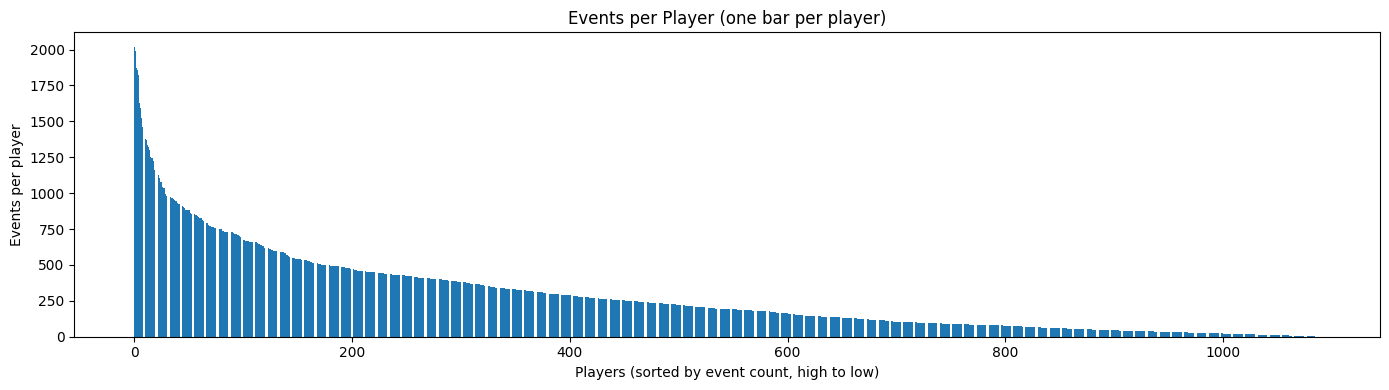

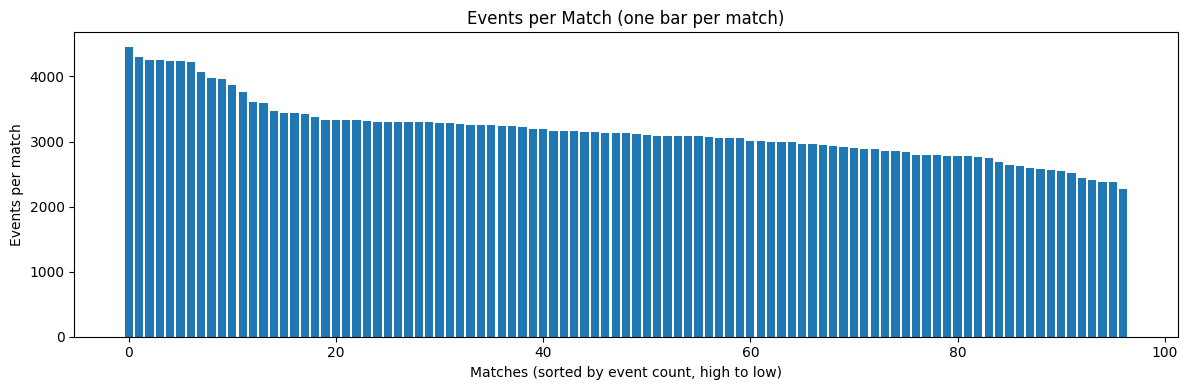

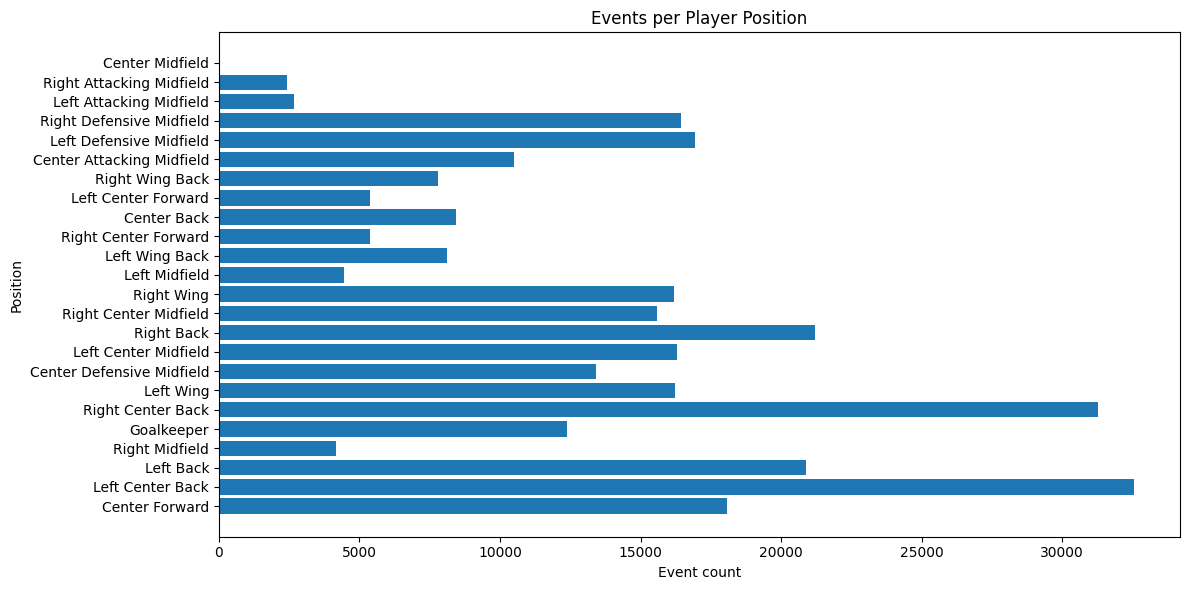

In [46]:
# Summary statistics and distributions

import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

player_counts = Counter()
match_counts = Counter()
position_counts = Counter()

# Robust JSONL reader (handles multiple JSON objects per line)

def iter_json_objects(fp):
    decoder = json.JSONDecoder()
    for line in fp:
        line = line.strip()
        if not line:
            continue
        idx = 0
        while idx < len(line):
            obj, end = decoder.raw_decode(line, idx)
            yield obj
            idx = end
            while idx < len(line) and line[idx].isspace():
                idx += 1

with OUTPUT_PATH.open('r', encoding='utf-8') as f:
    for ev in iter_json_objects(f):
        pid = ev.get('player.id')
        if pid is not None:
            player_counts[pid] += 1
        match_id = ev.get('match_id')
        if match_id is not None:
            match_counts[match_id] += 1
        pos_name = ev.get('position.name')
        if pos_name is not None:
            position_counts[pos_name] += 1

print('Processed events:', sum(match_counts.values()))
print('Unique players:', len(player_counts))
print('Unique matches:', len(match_counts))
print('Unique positions:', len(position_counts))

# Events per player (sorted, one bar per player)
player_items = sorted(player_counts.items(), key=lambda x: x[1], reverse=True)
player_vals = [v for _, v in player_items]

plt.figure(figsize=(14, 4))
plt.bar(range(len(player_vals)), player_vals)
plt.xlabel('Players (sorted by event count, high to low)')
plt.ylabel('Events per player')
plt.title('Events per Player (one bar per player)')
plt.tight_layout()
plt.show()

# Events per match (sorted, one bar per match)
match_items = sorted(match_counts.items(), key=lambda x: x[1], reverse=True)
match_vals = [v for _, v in match_items]

plt.figure(figsize=(12, 4))
plt.bar(range(len(match_vals)), match_vals)
plt.xlabel('Matches (sorted by event count, high to low)')
plt.ylabel('Events per match')
plt.title('Events per Match (one bar per match)')
plt.tight_layout()
plt.show()

# Events per player position
positions = list(position_counts.keys())
counts = [position_counts[p] for p in positions]

plt.figure(figsize=(12, 6))
plt.barh(positions, counts)
plt.ylabel('Position')
plt.xlabel('Event count')
plt.title('Events per Player Position')
plt.tight_layout()
plt.show()


In [47]:
# Count features after flattening

import json

cols = set()
rows = 0
with OUTPUT_PATH.open('r', encoding='utf-8') as f:
    for ev in iter_json_objects(f):
        rows += 1
        for k in ev.keys():
            cols.add(k)

print('Rows:', rows)
print('Flattened feature count:', len(cols))
print('Sample features:', sorted(list(cols))[:50])


Rows: 306890
Flattened feature count: 79
Sample features: ['50_50', 'ball_receipt', 'ball_receipt.outcome.id', 'ball_receipt.outcome.name', 'ball_recovery', 'block', 'carry', 'carry.end_location', 'clearance', 'clearance.body_part.id', 'clearance.body_part.name', 'counterpress', 'dribble', 'duel', 'duel.type.id', 'duel.type.name', 'duration', 'foul_committed', 'foul_won', 'freeze_frame', 'goalkeeper', 'index', 'interception', 'location', 'location_bucket.label', 'location_bucket.x_bin', 'location_bucket.y_bin', 'match_id', 'minute', 'miscontrol', 'pass', 'pass.angle', 'pass.angle_bucket', 'pass.backheel', 'pass.body_part.id', 'pass.body_part.name', 'pass.cross', 'pass.cut_back', 'pass.deflected', 'pass.end_location', 'pass.end_location_bucket.label', 'pass.end_location_bucket.x_bin', 'pass.end_location_bucket.y_bin', 'pass.goal_assist', 'pass.height.id', 'pass.height.name', 'pass.length', 'pass.length_bucket', 'pass.miscommunication', 'pass.outcome.id']
